# 01 - Inspect AI4Arctic RTT Data

Goal: Understand the data structure before building the baseline.

- What variables are available?
- What are the SAR channels?
- What are the target labels?
- What values need to be ignored (255)?

In [2]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Set data path
DATA_ROOT = "../data/ai4arctic_hugging face"
TRAIN_DIR = f"{DATA_ROOT}/train"
TEST_DIR = f"{DATA_ROOT}/test"

## 1. Count Files

In [3]:
train_files = sorted(glob.glob(f"{TRAIN_DIR}/*.nc"))
test_files = sorted(glob.glob(f"{TEST_DIR}/*.nc"))

print(f"Train files: {len(train_files)}")
print(f"Test files:  {len(test_files)}")
print(f"\nFirst train file: {train_files[0].split('/')[-1]}")

Train files: 512
Test files:  40

First train file: 20180108T184332_dmi_prep.nc


## 2. Inspect One Scene

In [4]:
# Load first scene
ds = xr.open_dataset(train_files[0])
print("Variables in dataset:")
print("=" * 70)
for name, var in ds.data_vars.items():
    arr = var.values
    print(f"{name:30s} shape={str(var.shape):20s} dtype={str(var.dtype):10s}")

Variables in dataset:
SIC                            shape=(5353, 5180)         dtype=uint8     
SOD                            shape=(5353, 5180)         dtype=uint8     
FLOE                           shape=(5353, 5180)         dtype=uint8     
sar_grid2d_latitude            shape=(23, 21)             dtype=float64   
sar_grid2d_longitude           shape=(23, 21)             dtype=float64   
nersc_sar_primary              shape=(5353, 5180)         dtype=float32   
nersc_sar_secondary            shape=(5353, 5180)         dtype=float32   
sar_incidenceangle             shape=(5353, 5180)         dtype=float32   
distance_map                   shape=(5353, 5180)         dtype=float32   
btemp_6_9h                     shape=(214, 207)           dtype=float32   
btemp_6_9v                     shape=(214, 207)           dtype=float32   
btemp_7_3h                     shape=(214, 207)           dtype=float32   
btemp_7_3v                     shape=(214, 207)           dtype=float32   
bte

In [5]:
# Detailed stats for each variable
print("\nVariable Statistics:")
print("=" * 70)
for name, var in ds.data_vars.items():
    arr = var.values
    valid = arr[~np.isnan(arr)] if arr.dtype == np.float32 else arr[arr != 255]
    print(f"{name}:")
    print(f"  min={np.nanmin(arr):.3f}, max={np.nanmax(arr):.3f}, mean={np.nanmean(arr):.3f}")
    print(f"  unique values: {len(np.unique(arr))}")
    print()


Variable Statistics:
SIC:
  min=0.000, max=255.000, mean=81.061
  unique values: 7

SOD:
  min=0.000, max=255.000, mean=176.495
  unique values: 6

FLOE:
  min=0.000, max=255.000, mean=116.372
  unique values: 5

sar_grid2d_latitude:
  min=67.297, max=71.980, mean=69.707
  unique values: 483

sar_grid2d_longitude:
  min=-28.850, max=-15.640, mean=-21.835
  unique values: 483

nersc_sar_primary:
  min=-10.875, max=4.907, mean=0.281
  unique values: 7413662

nersc_sar_secondary:
  min=-8.898, max=7.376, mean=0.165
  unique values: 4946366

sar_incidenceangle:
  min=-1.747, max=1.504, mean=0.027
  unique values: 16146382

distance_map:
  min=-1.576, max=1.025, mean=-0.084
  unique values: 40

btemp_6_9h:
  min=-1.095, max=1.504, mean=0.287
  unique values: 14276

btemp_6_9v:
  min=-1.145, max=1.416, mean=0.232
  unique values: 10436

btemp_7_3h:
  min=-1.096, max=1.498, mean=0.284
  unique values: 14311

btemp_7_3v:
  min=-1.141, max=1.420, mean=0.228
  unique values: 10482

btemp_10_7h:

## 3. Identify SAR Channels (Inputs)

In [6]:
# Find SAR variables
sar_vars = [k for k in ds.data_vars if 'sar' in k.lower()]
print(f"SAR variables: {sar_vars}")

# Show their shapes
for var in sar_vars:
    print(f"  {var}: {ds[var].shape}")

SAR variables: ['sar_grid2d_latitude', 'sar_grid2d_longitude', 'nersc_sar_primary', 'nersc_sar_secondary', 'sar_incidenceangle']
  sar_grid2d_latitude: (23, 21)
  sar_grid2d_longitude: (23, 21)
  nersc_sar_primary: (5353, 5180)
  nersc_sar_secondary: (5353, 5180)
  sar_incidenceangle: (5353, 5180)


## 4. Identify Target Labels

In [9]:
# Find target variables
all_vars = list(ds.data_vars.keys())

sod_vars = [k for k in all_vars if 'sod' in k.lower()]
sic_vars = [k for k in all_vars if 'sic' in k.lower()]
floe_vars = [k for k in all_vars if 'floe' in k.lower()]

print(f"SOD (Stage of Development): {sod_vars}")
print(f"SIC (Sea Ice Concentration): {sic_vars}")
print(f"FLOE (Floe Size): {floe_vars}")

SOD (Stage of Development): ['SOD']
SIC (Sea Ice Concentration): ['SIC']
FLOE (Floe Size): ['FLOE']


In [10]:
# Check unique values in SOD (our baseline target)
if sod_vars:
    sod = ds[sod_vars[0]].values
    unique_sod = np.unique(sod)
    print(f"SOD unique values: {unique_sod}")
    print(f"SOD num classes (excluding 255): {len(unique_sod[unique_sod != 255])}")
    print(f"\nPixels with value 255 (ignore): {np.mean(sod == 255)*100:.1f}%")

SOD unique values: [  0   1   2   3   4 255]
SOD num classes (excluding 255): 5

Pixels with value 255 (ignore): 69.2%


## 5. Visualize One Scene

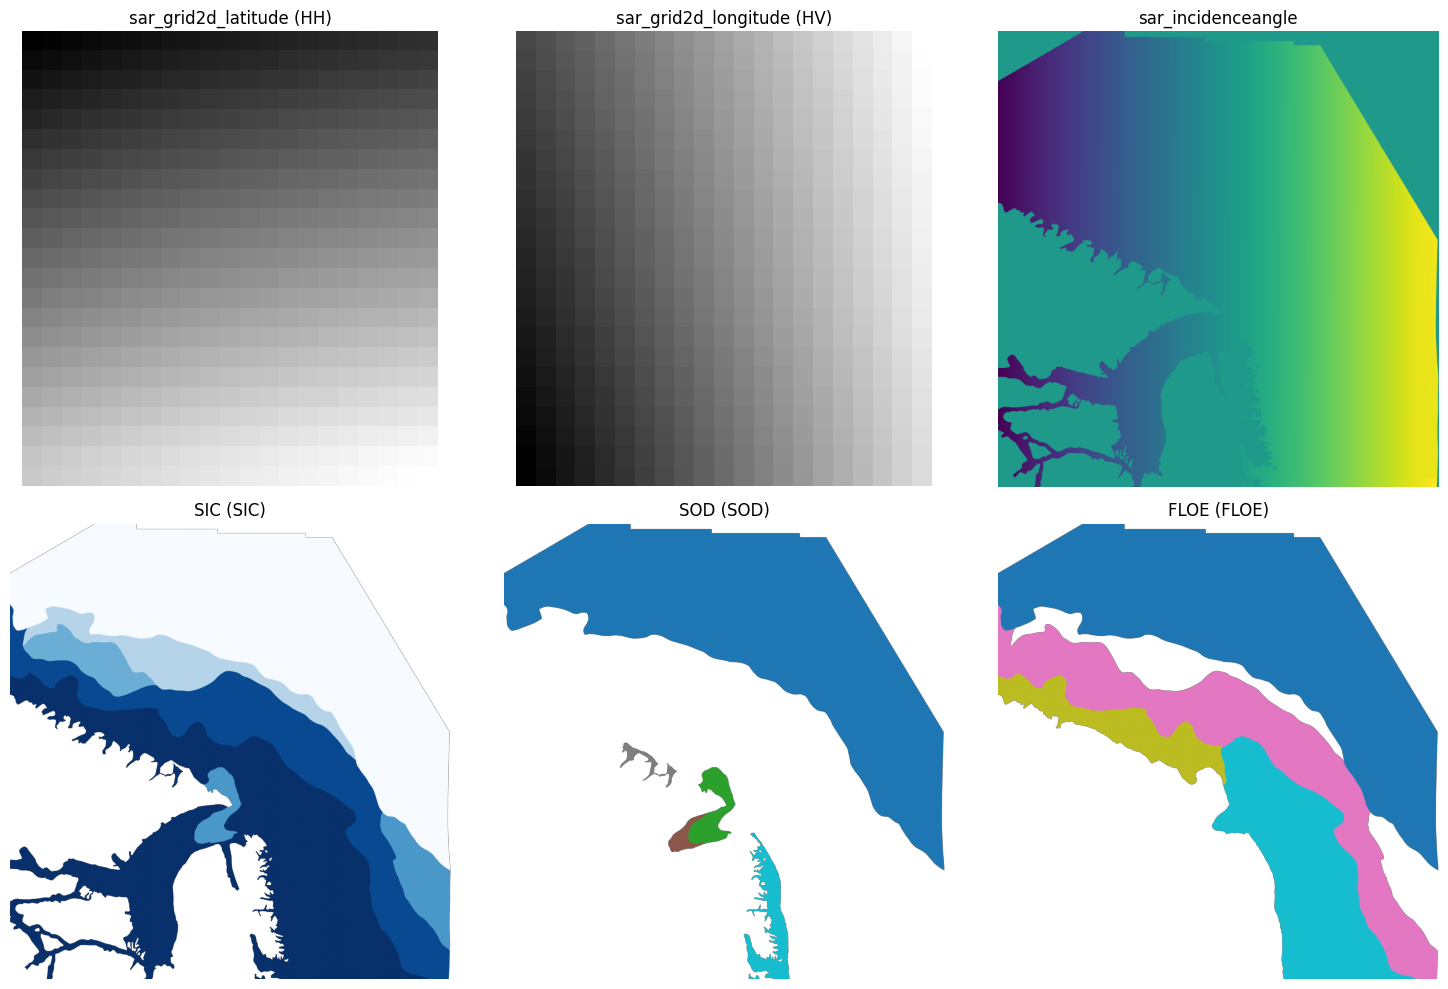

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# SAR channels
if len(sar_vars) >= 2:
    axes[0, 0].imshow(ds[sar_vars[0]].values, cmap='gray')
    axes[0, 0].set_title(f'{sar_vars[0]} (HH)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(ds[sar_vars[1]].values, cmap='gray')
    axes[0, 1].set_title(f'{sar_vars[1]} (HV)')
    axes[0, 1].axis('off')

# Incidence angle if available
inc_vars = [k for k in all_vars if 'incidence' in k.lower() or 'angle' in k.lower()]
if inc_vars:
    axes[0, 2].imshow(ds[inc_vars[0]].values, cmap='viridis')
    axes[0, 2].set_title(f'{inc_vars[0]}')
    axes[0, 2].axis('off')

# Targets
if sic_vars:
    sic_data = ds[sic_vars[0]].values.copy().astype(float)
    sic_data[sic_data == 255] = np.nan
    axes[1, 0].imshow(sic_data, cmap='Blues')
    axes[1, 0].set_title(f'{sic_vars[0]} (SIC)')
    axes[1, 0].axis('off')

if sod_vars:
    sod_data = ds[sod_vars[0]].values.copy().astype(float)
    sod_data[sod_data == 255] = np.nan
    axes[1, 1].imshow(sod_data, cmap='tab10')
    axes[1, 1].set_title(f'{sod_vars[0]} (SOD)')
    axes[1, 1].axis('off')

if floe_vars:
    floe_data = ds[floe_vars[0]].values.copy().astype(float)
    floe_data[floe_data == 255] = np.nan
    axes[1, 2].imshow(floe_data, cmap='tab10')
    axes[1, 2].set_title(f'{floe_vars[0]} (FLOE)')
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 6. Summary - Variables for Baseline

In [12]:
print("=" * 70)
print("SUMMARY: Variables for 3-Channel SAR Baseline")
print("=" * 70)
print(f"\nINPUTS (3 channels):")
print(f"  1. {sar_vars[0] if sar_vars else 'TBD'} - SAR HH polarization")
print(f"  2. {sar_vars[1] if len(sar_vars) > 1 else 'TBD'} - SAR HV polarization")
print(f"  3. {inc_vars[0] if inc_vars else 'TBD'} - Incidence angle")
print(f"\nTARGET (single task):")
print(f"  {sod_vars[0] if sod_vars else 'TBD'} - Stage of Development")
print(f"  Classes: {len(unique_sod[unique_sod != 255])} (ignore_index=255)")
print(f"\nScene shape: {ds[sar_vars[0]].shape if sar_vars else 'TBD'}")

SUMMARY: Variables for 3-Channel SAR Baseline

INPUTS (3 channels):
  1. sar_grid2d_latitude - SAR HH polarization
  2. sar_grid2d_longitude - SAR HV polarization
  3. sar_incidenceangle - Incidence angle

TARGET (single task):
  SOD - Stage of Development
  Classes: 5 (ignore_index=255)

Scene shape: (23, 21)


In [13]:
# Close dataset
ds.close()